In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [5]:
data = pd.read_pickle('data.bin')

In [6]:
data.head()

WEEK           PLN                          PLN_LABEL  \
0 2016-05-29  4.000022e+10  NIDO MILK PWDR NIDO FCRM  28.16OZ   
1 2016-05-29  4.000022e+10  NIDO MILK PWDR NIDO FCRM  28.16OZ   
2 2016-05-29  4.000076e+10  FUNGICURE ANTIFUNGL LIQ       1OZ   
3 2016-05-29  4.000076e+10  FUNGICURE ANTIFUNGL LIQ       1OZ   
4 2016-05-29  4.000076e+10  FUNGICURE ANTIFUNGL LIQ       1OZ   

  PRODUCT_CATEGORY PRODUCT_CATEGORY_LABEL  OPSTUDY      OPSTUDY_LABEL  ACTUAL  \
0          006-108                 ETHNIC      6.0  GENERAL GROCERIES     2.0   
1          006-108                 ETHNIC      6.0  GENERAL GROCERIES    36.0   
2          047-001            ANTI-FUNGAL     47.0         FOOT NEEDS  1198.0   
3          047-001            ANTI-FUNGAL     47.0         FOOT NEEDS     9.0   
4          047-001            ANTI-FUNGAL     47.0         FOOT NEEDS  1479.0   

                BU SEG PROMO  
0      Consumables   B     N  
1      Consumables  C4     N  
2  Health/Wellness   A     Y  
3  Health/Wellness   A     N  
4  Health/Wellness  C1     Y

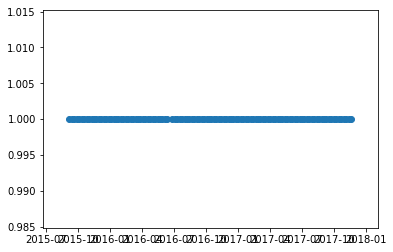

In [7]:
dates = data.WEEK.unique()
plt.scatter(dates,np.ones(len(dates)))

In [8]:
data.describe()

PLN       OPSTUDY        ACTUAL
count  1.609717e+07  1.609717e+07  1.609717e+07
mean   4.000054e+10  1.377965e+02  4.966591e+02
std    2.698768e+05  6.242574e+01  3.606525e+03
min    4.000010e+10  2.000000e+00 -2.844000e+04
25%    4.000033e+10  9.000000e+01  4.000000e+00
50%    4.000046e+10  1.590000e+02  2.800000e+01
75%    4.000082e+10  1.920000e+02  2.860000e+02
max    4.000100e+10  2.200000e+02  2.678932e+06

In [9]:
def remove_outliers(series,factor=3):
    return series[(series-series.mean())<factor*series.std()]

In [10]:
data_by_categories = data.groupby('PRODUCT_CATEGORY')
categories = data_by_categories.groups.keys()

In [11]:
data_on_test_category = data_by_categories.get_group('047-005')
sales_on_category = data_on_test_category.groupby('WEEK').ACTUAL.sum()

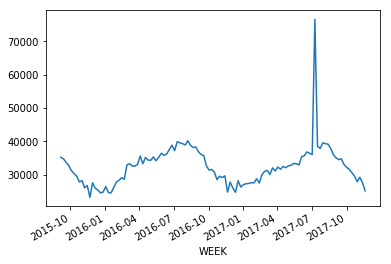

In [12]:
sales_on_category.plot()

In [13]:
cleaned_up_series = remove_outliers(sales_on_category)

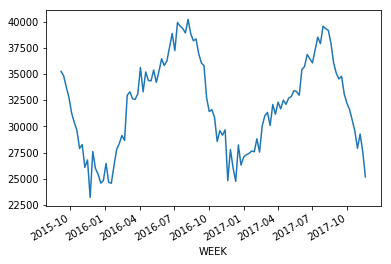

In [14]:
cleaned_up_series.plot()

In [46]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, winsize = 12):
    
    #Determing rolling statistics
    shift = int(np.floor(winsize/2))
    rolmean = timeseries.rolling(winsize).mean().shift(-shift)
    rolstd = timeseries.rolling(winsize).std().shift(-shift)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

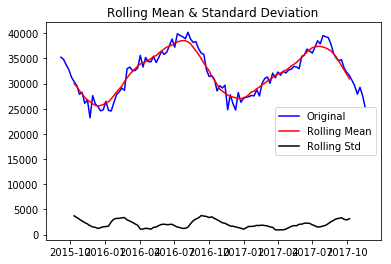

Results of Dickey-Fuller Test:
Test Statistic                  -3.228128
p-value                          0.018413
#Lags Used                       5.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [47]:
test_stationarity(cleaned_up_series)

In [1]:
def test_fun(sales_on_category):
    
    #cleaned_up_series = remove_outliers(sales_on_category)
    cleaned_up_series = sales_on_category
    try:
        dftest = adfuller(cleaned_up_series, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    except:
        dfoutput = pd.Series([np.nan, np.nan, np.nan, np.nan], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    return dfoutput

In [108]:
def chart_fun(timeseries,filename,cat_desc,winsize = 12):
    #Determing rolling statistics
    shift = int(np.floor(winsize/2))
    rolmean = timeseries.rolling(winsize).mean().shift(-shift)
    rolstd = timeseries.rolling(winsize).std().shift(-shift)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(cat_desc)
    plt.savefig('plots/'+filename+'.png')
    plt.clf()

In [109]:
categories_stat = pd.DataFrame(columns=['CAT','CAT_descr','Test Statistic','p-value','#Lags Used','Number of Observations Used'])
good_categories = []
test_cat = list(categories)[0:10]
for category in categories:  
    category_description = data_on_test_category.PRODUCT_CATEGORY_LABEL.iloc[0]
    result_header = pd.Series([category,category_description] ,index = ['CAT','CAT_descr'])
    
    data_on_test_category = data_by_categories.get_group(category)
    sales_on_category = data_on_test_category.groupby('WEEK').ACTUAL.sum()
    
    result = result_header.append(test_fun(sales_on_category))
    categories_stat = categories_stat.append(result, ignore_index = True)
    chart_fun(sales_on_category,category,category_description)
    if (result['p-value']<0.05):
        good_categories.append(category)
    

D:\Programs\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
D:\Programs\Anaconda\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
D:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\Programs\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


<Figure size 432x288 with 0 Axes>

In [110]:
categories_stat.head()

CAT       CAT_descr  Test Statistic       p-value  #Lags Used  \
0  002-060  S PM 24PK 12OZ       -1.129334  7.032331e-01         5.0   
1  002-061     750ML VODKA       -5.841649  3.765209e-07         0.0   
2  002-063  750ML BRANDY/C       -0.000000  9.585321e-01         7.0   
3  002-064  750ML BOURB WH        0.305451  9.775932e-01         3.0   
4  002-069  750ML CANAD WH       -5.594830  1.304203e-06         0.0   

   Number of Observations Used  
0                         92.0  
1                         97.0  
2                          3.0  
3                          8.0  
4                         97.0

In [ ]:
categories_stat.to_pickle('category_stat.bin')